#### Set-up

In [1]:

from post_processing import optimize_index, count_connected_components, post_process_mask, refine_overlapping_masks, filter_largest_connected_component
from vis_labeling import plot_whale_mask, visualize_all_masks, visualize_baseline_bboxes_individually, visualize_baseline_bboxes, visualize_ann_bboxes
from vis_labeling import read_cropped_image, calculate_bounding_box
from segment_anything import sam_model_registry, SamPredictor
import numpy as np
import json
import os
import sys
sys.path.append("..")

In [2]:
CATEGORIES = ['certain whale', 'certain whale', 'uncertain whale']

# Please download the checkpoint first: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth (2.4GB)
sam_checkpoint = "/data1/zhengyj/segment-anything/checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda:0")
predictor = SamPredictor(sam)

/data1/zhengyj/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


#### Visualize and export metadata

In [3]:
CW22 = ['22AUG01161709-P3DM_R06C2-015379185020_01_P001_81_83']

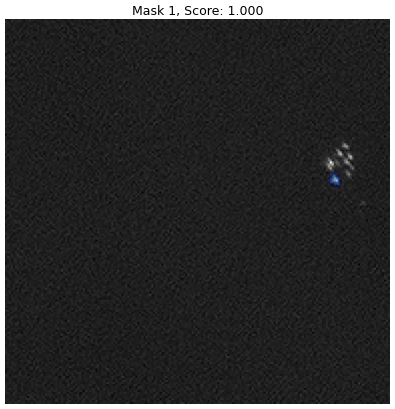

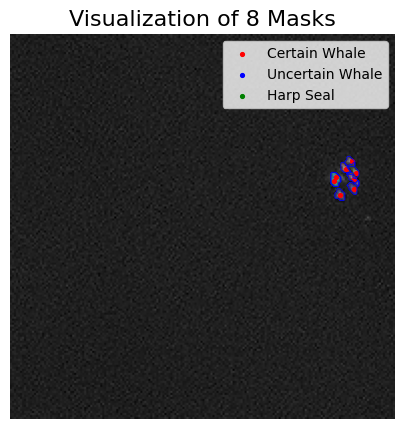

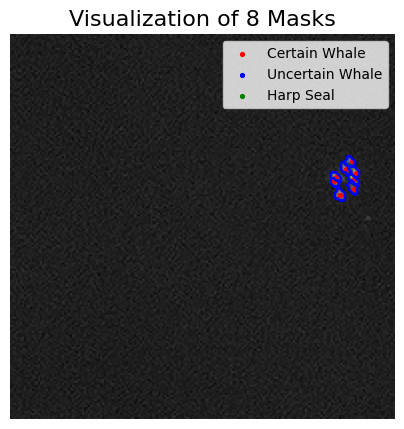

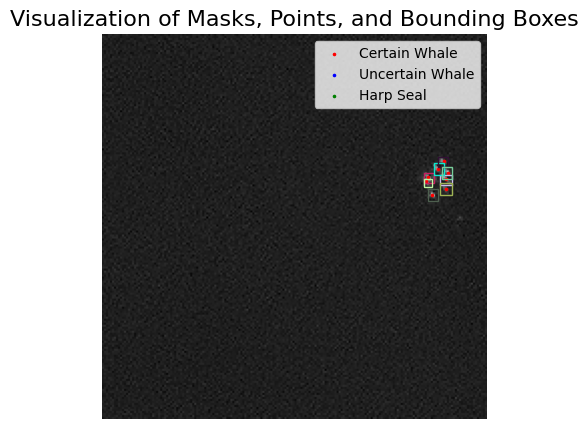

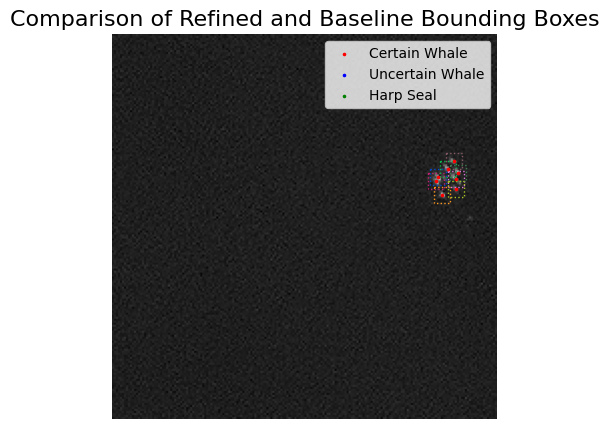

In [4]:
# crops_CW21_320, crops_Churchill_320, crops_CW22_192
cropped_images_dir, sat = 'crops_CW22_192', 'WV2'

save_dir = '/data1/zhengyj/mmyolo/datasets/beluga'
output_json_path = os.path.join(save_dir, 'annotations', f'metadata_{cropped_images_dir}_BUF_7.json')

BUFFER_SIZE_DICT = {
    'WV3': {
        'certain whale': 7,
        'uncertain whale': 7,
        'harp seal': 3,
    },
    'WV2': {
        'certain whale': 4,
        'uncertain whale': 4,
        'harp seal': 2,
    }
}

json_metadata_path = os.path.join(cropped_images_dir, 'metadata.json')
with open(json_metadata_path, 'r') as json_file:
    metadata = json.load(json_file)
crop_size = metadata['tiles'][0]['cropSize'][0] # 256 or 413

image_list = []
# Get filenames
for filename in os.listdir(cropped_images_dir):
    # print(filename[:-4])
    if filename.endswith('.tif') and filename[:-4] in CW22:
        # print(filename)
        image_list.append(filename)

for cnt, img_name in enumerate(image_list):
    cropped_image_path = os.path.join(cropped_images_dir, img_name)
    image = read_cropped_image(cropped_image_path, img_name)
    # Get window info
    found = False
    for tile in metadata['tiles']:
        for window in tile['windows']:
            if window['dataURL'] == img_name:
                found = True
                break
        if found:
            break

    # Swap [x, y] order for all labels before processing
    for label in window['labels']:
        label['pointIndex'] = label['pointIndex'][::-1]

    # Initialize masks storage
    all_masks = []
    all_points = []
    all_categories = []
    # Read the labels and prepare input points and labels
    for i, label in enumerate(window['labels']):
        # print(label['class'])
        if label['class'] in ('background', 'harp seals'):
            continue  # Skip background targets
        buffer_size = BUFFER_SIZE_DICT[sat][label['class']]
        input_points = [label['pointIndex']]
        input_points = [optimize_index(image, label['pointIndex'], window_size=5)]
        input_labels = [1]  # Set current point as foreground
        input_box = None
        
        # Create box prompt
        point_row, point_col = input_points[0][0], input_points[0][1]
        input_box = [point_row - buffer_size, point_col - buffer_size, point_row + buffer_size, point_col + buffer_size]
        input_points, input_labels, input_box = np.array(input_points), np.array(input_labels), np.array(input_box)

        # generate masks
        predictor.set_image(image)
        masks, scores, low_res_masks = predictor.predict(
            point_coords=input_points, point_labels=input_labels,
            box=input_box,
            multimask_output=False, return_logits=False
        )
        cnt_cmp = count_connected_components(masks[0])
        if cnt_cmp > 1:
            print(cnt_cmp, cnt, img_name)
        masks = post_process_mask(masks, input_box)
        all_masks.append(masks[0])  # Store the single mask
        all_points.append(label['pointIndex'])  # Store the point index
        all_categories.append(label['class'])

    if all_masks:
        for i, mask in enumerate(all_masks):
            plot_whale_mask(image, np.array([all_points[i]]), np.array([1]), None, [mask], [1.0], figsize=(10, 10), dpi=50)
            break
        visualize_all_masks(image, all_masks, all_points, categories=all_categories, figsize=(5, 5))

        refined_masks = refine_overlapping_masks(all_masks, all_points)
        refined_masks = [filter_largest_connected_component(mask) for mask in refined_masks]

        visualize_all_masks(image, refined_masks, all_points, categories=all_categories, figsize=(5, 5))
        visualize_ann_bboxes(image, refined_masks, all_points, categories=all_categories, figsize=(5, 5))
        visualize_baseline_bboxes(image, refined_masks, all_points, buffer_size=buffer_size, categories=all_categories, figsize=(5, 5)) # categories=all_categories,
        # visualize_baseline_bboxes_individually(image, refined_masks, all_points, buffer_size=buffer_size)
        
        # write box annoation to metadata
        non_background_label_index = 0
        for label in window['labels']:
            if label['class'] not in ('certain whale', 'uncertain whale', 'harp seal'):
                continue  # Skip background targets
            label['bbox'] = calculate_bounding_box(refined_masks[non_background_label_index])
            non_background_label_index += 1
    # break

# with open(output_json_path, 'w') as output_file:
#     json.dump(metadata, output_file, indent=4)
# print(f'Saved updated metadata to {output_json_path}')

In [5]:
cropped_images_dir = 'crops_Churchill_320'  # crops_CW21_320
output_json_path = os.path.join(save_dir, 'annotations', f'metadata_{cropped_images_dir}.json')
with open(output_json_path, 'w') as output_file:
    json.dump(metadata, output_file, indent=4)
print(f'Saved updated metadata to {output_json_path}')

Saved updated metadata to /data1/zhengyj/mmyolo/datasets/beluga/annotations/metadata_crops_Churchill_320.json


#### Export buffer box annotations

In [6]:
cropped_images_dir = 'crops_CW21_320'  # crops_CW21_320, crops_Churchill_320, crops_CW22_192
sat = 'WV3'
save_dir = '/data1/zhengyj/mmyolo/datasets/beluga'
output_json_path = os.path.join(save_dir, 'annotations', f'metadata_{cropped_images_dir}_box_BUF_6.json')

BUFFER_SIZE_DICT = {
    'WV3': {
        'certain whale': 7,
        'uncertain whale': 6,
        'harp seal': 3,
    },
    'WV2': {
        'certain whale': 4,
        'uncertain whale': 4,
        'harp seal': 2,
    }
}

json_metadata_path = os.path.join(cropped_images_dir, 'metadata.json')
with open(json_metadata_path, 'r') as json_file:
    metadata = json.load(json_file)
crop_size = metadata['tiles'][0]['cropSize'][0] # 256 or 413

image_list = []
# Get filenames
for filename in os.listdir(cropped_images_dir):
    if filename.endswith('.tif'):
        image_list.append(filename)

for cnt, img_name in enumerate(image_list):
    print(cnt, img_name)
    cropped_image_path = os.path.join(cropped_images_dir, img_name)
    image = read_cropped_image(cropped_image_path, img_name)
    # Get window info
    found = False
    for tile in metadata['tiles']:
        for window in tile['windows']:
            if window['dataURL'] == img_name:
                found = True
                break
        if found:
            break

    # Swap [x, y] order for all labels before processing
    for label in window['labels']:
        label['pointIndex'] = label['pointIndex'][::-1]

    # Initialize masks storage
    all_masks = []
    all_points = []

    # Read the labels and prepare input points and labels
    for i, label in enumerate(window['labels']):
        # print(label['class'])
        if label['class'] in ('background', 'harp seals'):
            continue  # Skip background targets
        buffer_size = BUFFER_SIZE_DICT[sat][label['class']]
        input_points = optimize_index(image, label['pointIndex'], window_size=5)
        bbox = [int(input_points[0] - buffer_size), int(input_points[1] - buffer_size), int(buffer_size*2), int(buffer_size*2)]
        label['bbox'] = bbox    # [x, y, w, h], [x, y] is the coordinate of the top-left corner of the bounding box
        

# with open(output_json_path, 'w') as output_file:
#     json.dump(metadata, output_file, indent=4)
# print(f'Saved updated metadata to {output_json_path}')

0 21SEP07162713-P3DS_R06C3-014413001050_01_P002_25_47.tif
1 21SEP07162638-P3DS_R05C2-014413001050_01_P003_41_27.tif
2 21SEP07162703-P3DS_R08C3-014413001050_01_P001_18_20.tif
3 21SEP07162713-P3DS_R09C3-014413001050_01_P002_32_0.tif
4 21SEP07162713-P3DS_R08C1-014413001050_01_P002_9_28.tif
5 21SEP07162703-P3DS_R03C2-014413001050_01_P001_11_49.tif
6 21SEP07162703-P3DS_R08C1-014413001050_01_P001_24_6.tif
7 21SEP07162703-P3DS_R08C2-014413001050_01_P001_49_16.tif
8 21SEP07162713-P3DS_R10C3-014413001050_01_P002_23_12.tif
9 21SEP07162713-P3DS_R06C3-014413001050_01_P002_30_51.tif
10 21SEP07162713-P3DS_R02C2-014413001050_01_P002_4_15.tif
11 21SEP07162703-P3DS_R03C2-014413001050_01_P001_17_48.tif
12 21SEP07162713-P3DS_R10C3-014413001050_01_P002_1_33.tif
13 21SEP07162713-P3DS_R09C1-014413001050_01_P002_25_16.tif
14 21SEP07162703-P3DS_R03C2-014413001050_01_P001_17_51.tif
15 21SEP07162713-P3DS_R01C2-014413001050_01_P002_21_9.tif
16 21SEP07162703-P3DS_R06C2-014413001050_01_P001_24_5.tif
17 21SEP071626

#### Convert tif to png

In [7]:
# cropped_images_dir = 'crops_CW22_192'  # crops_CW21_320, crops_Churchill_320, crops_CW22_192
# save_png_dir = '/data1/zhengyj/mmyolo/datasets/beluga/images_v2'

# # Get filename list
# image_list = []
# for filename in os.listdir(cropped_images_dir):
#     if filename.endswith('.tif'):
#         image_list.append(filename)

# for cnt, img_name in enumerate(image_list):
#     cropped_image_path = os.path.join(cropped_images_dir, img_name)
#     image = read_cropped_image(cropped_image_path, img_name, save_as_png=True, save_dir=save_png_dir)